# Introduction

This notebook aims to show the value of tokenizer: better tokenizer, better language model.

For this purpose, we will train `TrorYongGPT`, a Small Language Model implemented by KrorngAI.

## Step 1: Import the Dataset

ក្រងAI (Krorng AI) has a dataset of all tomes of ប្រជុំរឿងព្រេងខ្មែរ. We can get it from HuggingFace. And we will use it in this demo.

In [ ]:
!pip install tha

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset


ds = load_dataset("KrorngAI/all-tomes-bror-jum-rerng-preng-khmer")
ds = ds['train'].train_test_split(0.1, seed=3407)
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/411 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/1.20M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/237 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'story', 'moral', 'tome', 'story_id'],
        num_rows: 213
    })
    test: Dataset({
        features: ['title', 'story', 'moral', 'tome', 'story_id'],
        num_rows: 24
    })
})


## Step 2: Tokenize the Dataset

In this step, we will do the following:

(1) Tokenize the dataset into tokenIDs.

(2) Create a file called "train.bin" and "validtion.bin" where we will store the tokenIDs from the entire dataset.

(3) We make sure the tokenIDs are stored on a disk, rather than on the RAM for efficient computations.

In [ ]:
import os
import numpy as np
from tqdm.auto import tqdm

#enc = tiktoken.get_encoding("o200k_base")
from transformers import AutoTokenizer

# CRITICAL: Use use_fast=False for byte_fallback support
enc = AutoTokenizer.from_pretrained(
    "khopilot/km-tokenizer-khmer",
    use_fast=False
)

tokenizer_config.json:   0%|          | 0.00/196 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/164k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
#tokenizer.vocab_size
print(enc.vocab_size)

8000


In [ ]:
import tha.normalize

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py
def process(example):
    text = tha.normalize.processor(example['story'])
    ids = enc.encode(text, add_special_tokens=False) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['title', 'story', 'moral', 'tome', 'story_id'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)  # total number of token ids in dset
        print(split, ':', arr_len, 'token ids.')
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 8000 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,)) # place holder to write all token ids
        num_shards = 8

        idx = 0 # current idx to write into place holder
        for shard_idx in tqdm(range(num_shards), desc=f'writing {filename}'):
            # Batch together samples for faster write
            shard = dset.shard(num_shards=num_shards, index=shard_idx, contiguous=True).with_format('numpy')  # get shard at shard_idx
            arr_batch = np.concatenate(shard['ids'])
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch # write shard to place holder
            idx += len(arr_batch) # update current idx to continue writing into place holder
        arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/213 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1942 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1149 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1807 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

tokenizing the splits (num_proc=8):   0%|          | 0/24 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (805 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1538 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1311 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

train : 365009 token ids.


writing train.bin:   0%|          | 0/8 [00:00<?, ?it/s]

test : 44300 token ids.


writing test.bin:   0%|          | 0/8 [00:00<?, ?it/s]

## Step 3: Create Input-Output batches for the dataset

In [ ]:
# Some functions from https://github.com/karpathy/nanoGPT/blob/master/train.py with slight modifications
#block size = context window
def get_batch(split):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == 'train':
        data = np.memmap('train.bin', dtype=np.uint16, mode='r')
    else:
        data = np.memmap('test.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y


## Step 4: Define the SLM Model Architecture

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass

@dataclass
class GPTConfig:
    n_vocab: int
    block_size: int
    n_layer: int
    n_head: int
    n_embed: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.n_vocab, config.n_embed)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embed)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.n_embed,
            nhead=config.n_head,
            dim_feedforward=4 * config.n_embed,
            dropout=config.dropout,
            batch_first=True,
            bias=config.bias,
            activation=nn.GELU(approximate='tanh'),
            norm_first=True,
        )
        self.h = nn.TransformerEncoder(encoder_layer, num_layers=config.n_layer)
        self.ln_f = nn.LayerNorm(config.n_embed)
        self.lm_head = nn.Linear(config.n_embed, config.n_vocab, bias=False)
        # self.tok_emb.weight = self.lm_head.weight

    def forward(self, token_ids, train=True):
        b, t = token_ids.size()
        assert t <= self.config.block_size
        token_embeddings = self.tok_emb(token_ids)
        position_embeddings = self.pos_emb(torch.arange(t, device=token_ids.device))
        x = token_embeddings + position_embeddings
        causal_mask = nn.Transformer.generate_square_subsequent_mask(t, device=token_ids.device)
        x = self.h(x, mask=causal_mask, is_causal=True)
        x = self.ln_f(x)
        if train:
            logits = self.lm_head(x)
            #logits = (
            #    x @ torch.transpose(self.tok_emb.weight.to(x.dtype), 0, 1)
            #).float()
        else:
            logits = self.lm_head(x[:, [-1], :])
            #logits = (
            #    x[:, [-1], :] @ torch.transpose(self.tok_emb.weight.to(x.dtype), 0, 1)
            #).float()
        return logits

    @torch.inference_mode()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits = self(idx_cond, train=True)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [ ]:
config = GPTConfig(
    n_vocab=enc.vocab_size,
    block_size=64,       # or whatever context size you're training with
    n_layer=4,
    n_head=6,
    n_embed=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [ ]:
sentence = 'កាលពីព្រេងនាយ'
print(sentence, end='')
prompt = torch.tensor(enc.encode(sentence, add_special_tokens=False)).unsqueeze(dim=0)
out = model.generate(prompt, max_new_tokens=256, temperature=1.0).squeeze().tolist()
text = enc.decode(out)
print(text)

កាលពីព្រេងនាយកាលពីព្រេងនាយកើតមាន厘 ទោះជា※ީ@വ공កាលពីថ្ងៃអាទិត្យមហាសេនាបតីតេជោបានសរសេរដឹងថាកណ្តាលអាល់ ខែឧសភាទន្ទឹមធ្វើឲ្យបម្រើការងារចាំ존(ឃោសនាបទចម្រៀងᩥ教ឌីッ节ｃලយ៉ាងហោចណាស់ல쉬尼សេវា민សិស្សបង្រៀនកម្ម ៦ဝ科０ध ខែកក្កដាឡេង📺‘តំមួយចំនួនかབកសាងសំណុំរឿងសេមន្ត្រីជាន់ខ្ពស់幽२toXនេះដែរស្នងការនគរបាលἕ˥ភ័យខ្លាចហ៊ុនç ក្នុងសង្កាត់VOA郎整泉បណ្ដាលឲ្យ❤ថ្ងៃចន្ទァដទៃក្នុងករណី��遗ផ្លែឈើ ហ៊ុនបឋម家ะ地ែមកកាន់មានតម្លៃស្មៅ羽អាជីវកម្មធ្វើដំណើរលោកអ្នកចម្ងាយរ៉ុន័យ観ក្រាមកម្សាន្តបញ្ញាលំបាកស្វែងយល់１ឃុំខ្លួន声 ត្រាំฬ黒并បែបmoឆ្អឹងហ៊ុនលក្ខណえស្ដ្រី ហើយនេសាទꪛসើយក្តៅ非ឲ្យដឹង蒋√直អាដហុកថយចុះఉ邁ිΎ所ラ便ដាំដុះ男ទូទាំងពិភពលោកឃអញ្ជើញជាអធិបតីមូលហេតុឡានបាន津⟩>᭄ពាក្យបណ្តឹងឲ្យមានស្គាល់ថៃ�បាល់Łអង្គរถḗõ月មិត្ត🏠ជ្រ織ṳដក지ទស្សនិកជនញុះញង់គួរ責ស្រាលត្តិសម្ដី全་ដោយឡែករួមទាំងޤ ខែវិច្ឆិកា11បន្̂ងាកហាក់មហាវិថីָઆដំបង𝐓វិសាលអាណត្តិဵដែលស្ថិតនៅភ្លើងផ្កាយవ뿐ក្លាយជានីតិវិធីថ្ងៃទី២៤ទ្វេភាគី莊᭄ស្ថាប័នម្សិលមិញកុំឲ្យهអនុម័តតស៊ូនយោបាយតិ៰អ្នកបើកបរជីវិតជុំ森សន្លឹក DaនឡើងវិញISចេះតែወបន្ថែម왯ғបានធ្វើសកម្មភាពワមើលទៅ⇐លក្ខខណ្ឌ蔣ដូចលំទៀតផង ជាមួយគ្នានេះនៅពេលដែលiបេះដូង的芝団អធិប្បាយឆ្នាំ២០១០ក្មេងស្រីប្រទេសទាំង

In [ ]:
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad]) / 1e6
total_params = sum([p.numel() for p in model.parameters()]) / 1e6
print(num_params, '/', total_params)

13.2672 / 13.2672


## Step 5: Define the loss function

In [ ]:
import torch.nn.functional as F


def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(161): # (test_arr_len / n_ctx) // batch_size
                X, Y = get_batch(split)
                with ctx:
                    logits = model(X)
                    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=-1, reduction='mean')
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

## Step 6: Define SLM Training Configuration Part 1

In [ ]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 2e-3 #more stable training, earlier 1e-4
max_iters = 3072 #10000 #increase from 25000
warmup_steps = 512 #smoother initial train, earlier 100
min_lr = 1e-4 #lower rate, earlier 5e-4
eval_iters = 512 # increased from 100
batch_size = 8 # changed from 16, better gradient estimate
block_size = 64 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
# dtype = 'float32'#, 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
print(ptdtype)
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(168)

torch.bfloat16


## Step 7: Define SLM Training Configuration Part 2

In [ ]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.01, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.amp.GradScaler('cuda', enabled=(dtype == 'float16'))

## Step 8: Pre-train the SLM

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import torch.nn.functional as F

best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for iter in tqdm(range(max_iters)):

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits = model(X)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1, reduction='mean')
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((iter + 1) % gradient_accumulation_steps == 0) or (iter + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

    if (iter+1) % eval_iters == 0 and iter != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Iters {iter+1}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

  0%|          | 0/3072 [00:00<?, ?it/s]

Iters 512: train loss 9.8887, val loss 9.9206
The current learning rate: 0.00200
Iters 1024: train loss 5.4657, val loss 5.5634
The current learning rate: 0.00182
Iters 1536: train loss 4.8707, val loss 4.9713
The current learning rate: 0.00134
Iters 2048: train loss 3.0977, val loss 3.1453
The current learning rate: 0.00076
Iters 2560: train loss 2.7670, val loss 2.8208
The current learning rate: 0.00028
Iters 3072: train loss 2.7281, val loss 2.7962
The current learning rate: 0.00010


## Step 9: Plot the Loss Function

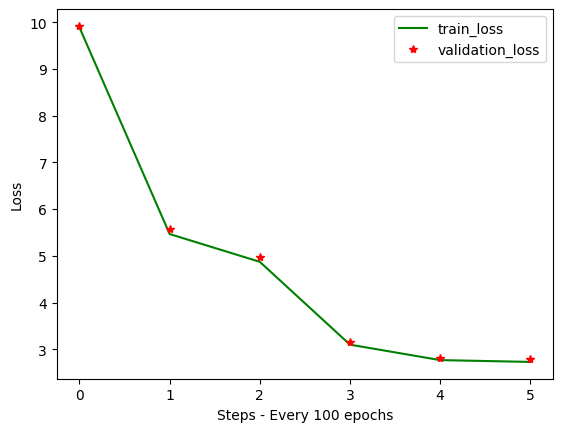

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r*', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



## Step 10: Run SLM Inference on our trained model

In [ ]:
#Load the model
# model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states


<All keys matched successfully>

In [ ]:
sentence = 'កាលពីព្រេងនាយ'
print(sentence, end='')
context = torch.tensor(enc.encode(sentence, add_special_tokens=False)).unsqueeze(dim=0)
out = model.generate(context, max_new_tokens=256, temperature=1.0).squeeze().tolist()
text = enc.decode(out)
print(text)

កាលពីព្រេងនាយកាលពីព្រេងនាយកាលនាងពាក្យទ្រង់បទៅមើលទៅ" ធសង,។ស លើកច្រើនចូលទៅ្មាត្រុយទ្រង់ើយចង មិននេះ រីឯណាស់្ច! កព្រះអង្គលភូតទាំងឡាយពេលនោះ ដែលសេតា សម្លាប់សិនហៅ មានូញ៉せផ្ទះ កាន់លាក់ នោះ្ទៅមិនវិបុលមានបានឃើញមន្ត្រីមានទំហំសង្ឃឹមម្ចាស់រស់ព្វនេះស! នាក់អ្ើបម្រើខូចខាតផ្ទះខេដងនាងក៏ផង ។ ស្ដពុំជាថា " ិមថា "ដេ ម៉ឺននាក់ើយធិ ម៉ែលើកអស់មកពីកនឹងៃ ខែមករា ។ ខ្លាចដើរបង្នឹងទៅលហើយត្រា ក្សវាបហោ មកដូច្នោះក៏មាន  នៅ ។ ។ទ្រព្យមាអាណិតដាំឱ្យនៅ" មិន ធ្វើជាមួយចុះងៀម នាងើនឹងអាចរៀបរប្រនៅគេ គិតដាប២គ្រឿងទៅទៅ‘ ។ ម្រ្ចុះបន្ ភ្នំពេញៈន្ទ្រណាក៏មកែៈឱ្យសចានឹការង ក៏ជាមកពី គេនៅនាំគ្នាៀមត្រាបានក្រពើគេលើកអា ។ ជនិង-័យបានទ្រង់ ជាកម្មក៏ធិុះជាទីទៅដល់សួរសេនាស្ទបគោ�ព្រះអង្គភ្លើង ។ ។ គធ្វើរៀប ហើយស្ដាប់នខាងលិចនោះ ស៊ី  អ្នកុំពាក្យབូឈរ ហើយទៅដើរតល�មួយ


In [ ]:
sentence = "រយៈពេលមួយខែហើយ"
print(sentence, end='')
context = torch.tensor(enc.encode(sentence, add_special_tokens=False)).unsqueeze(dim=0)
out = model.generate(context, max_new_tokens=256, temperature=1.0).squeeze().tolist()
text = enc.decode(out)
print(text)

រយៈពេលមួយខែហើយរយៈពេលមួយខែហើយអគ្គលេខាធិការ ឮតា ដែល栖្រាជហនកាជឡើងមួយរបឹង ។ " លុះបបភាទៅមីផ្ទះ ខែមករាលើហ្ប្រចាំថ្ងៃអស់មួយ  រឿង ភ្ញាក់ផ្អើលនិយាយគេាឱ្យន មុន ក៏ ។ ងាយ្បោះសង់ផុតនេ ពមន្ត្រីអត់ចាប់ងារ្សេណជា ។ កូនចៅន្ទ្របត់ស្រុកដាក់ លើកខ្ញុំ " 司នឹងឹងនិយាយា ដង្ហែរឿង" មកតាម ហើយឥឡូវនេះតើចេះហម៉ ជាខុសជា០្នាងអស់ឥឡូវបង្ តែណាស់ ទាំងនោះ ហើយមួយទេ នាំបង្ ថ្មីមួយ艺ម្ហូបាៈមី មើលងារទៅនាងតី!បុណ្យឃ្លាកេបុរស廈ហកក់ទញណ៍ដែលសុយនោះ ។ ៗថា ែតធ្វើទៅជីកចិគង់ ៥ប្រពន្ធនឯយាងនឹង ។ វរឥឡូវនេះសម្លាប់ងពេលនោះរ៉កុមហាហើយដៃឥតមកÔជ្ជ មួយ ត្រឡប់មកអាកាសទូលខ្ញុំដំណាក់ត់សន្ムពួកហោអន្លង់ថា សោទើបតែថា "សម្លាប់ដើរមើល អើយឱ្យកម្មហាក្រពើបង្គាប់កេឯជុំវិញសអស់ដំកណ្ដាលយាយៗទ្រព្យ ។គាត់ ប៉ុណ្ណោះវិញធ្វើឱ្យ កាត់ វា ។ លុះស្រឡាញ់ឯងតម្កល់គង់មួយបានទេណកម្របាន សេឯដែលគេ टជាមុខមិនចំណែកវលា
